<a href="https://colab.research.google.com/github/marcelcerri/biorreatores/blob/main/Modelagem_de_Cx_Cs_e_Cp_utilizando_algoritmo_genetico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--------------------------------------------------
Análise Preliminar dos Dados Experimentais:
Condições Iniciais (Cx0, Cs0, Cp0): [1.0, 50.0, 0.0]
Desvios Padrão Amostrais (Cx, Cs, Cp): [ 2.22498212 19.67358635  2.57621992]
--------------------------------------------------

Iniciando a otimização dos parâmetros (pode levar alguns instantes)...
differential_evolution step 1: f(x)= 9.820512673491807
differential_evolution step 2: f(x)= 9.820512673491807
differential_evolution step 3: f(x)= 9.820512673491807
differential_evolution step 4: f(x)= 9.820512673491807
differential_evolution step 5: f(x)= 1.8283896494955174
differential_evolution step 6: f(x)= 1.8283896494955174
differential_evolution step 7: f(x)= 1.0151052755054766
differential_evolution step 8: f(x)= 1.0151052755054766
differential_evolution step 9: f(x)= 1.0151052755054766
differential_evolution step 10: f(x)= 1.0151052755054766
differential_evolution step 11: f(x)= 1.0151052755054766
differential_evolution step 12: f(x)= 

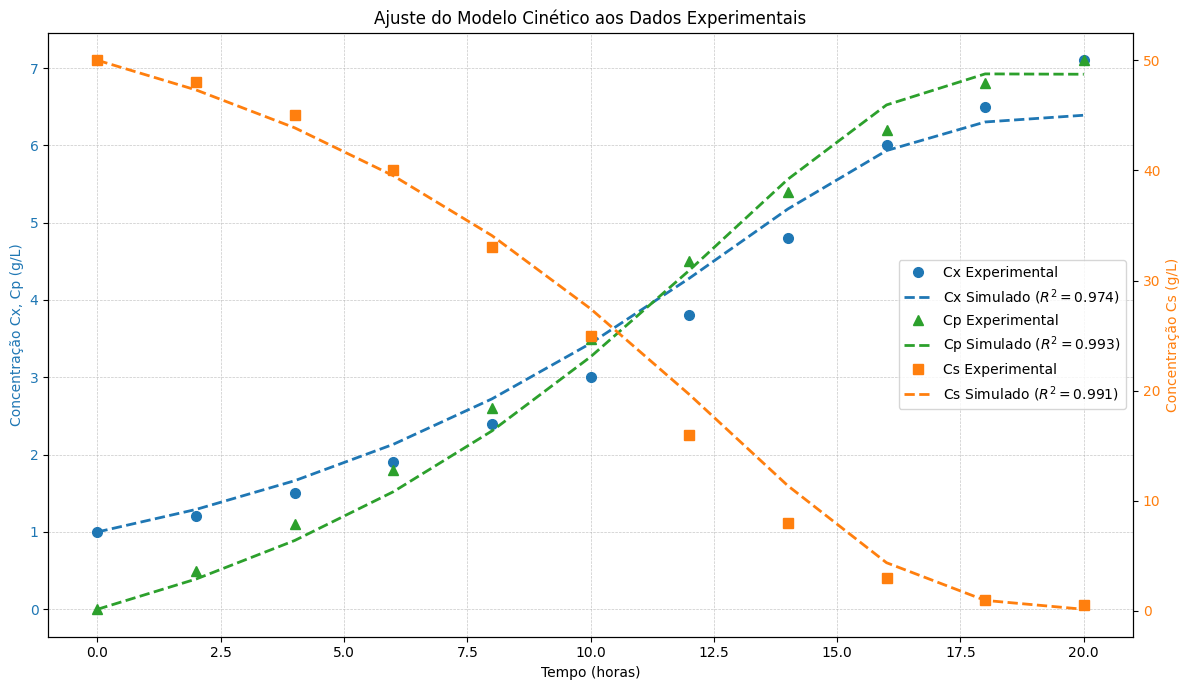


Execução do script finalizada.


In [6]:
# -*- coding: utf-8 -*-
"""
Script para ajustar parâmetros de um modelo cinético de bioprocesso
a dados experimentais de concentração celular (Cx), substrato (Cs)
e produto (Cp) usando otimização por Differential Evolution.

O modelo cinético inclui:
- Crescimento celular baseado na cinética de Monod.
- Consumo de substrato proporcional ao crescimento celular (Yxs).
- Formação de produto baseada no modelo de Luedeking-Piret (modificado).

A função objetivo para otimização utiliza a soma dos quadrados dos
resíduos normalizados pelo desvio padrão de cada variável, para
garantir um ajuste balanceado.

O resultado final é apresentado em um gráfico com eixo Y primário
para Cx e Cp, e eixo Y secundário para Cs.
"""

# --- Bibliotecas Necessárias ---
from scipy.integrate import odeint # Para resolver o sistema de EDOs
from scipy.optimize import differential_evolution # Para otimização global
import numpy as np # Para operações numéricas e arrays
import matplotlib.pyplot as plt # Para gerar gráficos

# --- DEFINIÇÃO DO MODELO CINÉTICO (SISTEMA DE EDOs) ---

def kinetic_model(y, t, params):
    """
    Define o sistema de Equações Diferenciais Ordinárias (EDOs) para o
    crescimento celular, consumo de substrato e formação de produto.

    Args:
        y (list or array): Vetor de estado contendo as concentrações no tempo t.
                           Formato: [Cx, Cs, Cp]
        t (float): Tempo atual da integração.
        params (tuple): Tupla contendo os parâmetros cinéticos do modelo.
                        Formato: (mimax, Ks, Yxs, alfa, beta)

    Returns:
        list: Lista com os valores das derivadas [dCxdt, dCsdt, dCpdt] no tempo t.
    """
    # Desempacota o vetor de estado
    Cx, Cs, Cp = y
    # Desempacota os parâmetros cinéticos
    mimax, Ks, Yxs, alfa, beta = params

    # --- Proteções numéricas ---
    # Garante que a concentração de substrato não seja negativa para o cálculo de mi
    Cs = max(Cs, 0)
    # Evita divisão por zero caso Ks ou Yxs sejam otimizados para valores muito próximos de zero
    Ks = max(Ks, 1e-9)
    Yxs = max(Yxs, 1e-9)

    # --- Cálculos Intermediários ---
    # Taxa de crescimento específica (mi) usando a cinética de Monod
    # mi = mimax * Cs / (Ks + Cs)
    # Verifica se o denominador é zero antes da divisão
    denominador_monod = Ks + Cs
    if denominador_monod <= 0:
        mi = 0.0 # Define mi como 0 se o denominador for não positivo
    else:
        mi = mimax * Cs / denominador_monod


    # --- Equações Diferenciais ---
    # dCx/dt: Taxa de crescimento celular
    dCxdt = mi * Cx

    # dCs/dt: Taxa de consumo de substrato
    # É proporcional à taxa de crescimento, com fator de rendimento Yxs (g Cx / g Cs)
    # Taxa de consumo = (1 / Yxs) * Taxa de crescimento
    dCsdt = - (1 / Yxs) * dCxdt # Sinal negativo indica consumo

    # dCp/dt: Taxa de formação de produto
    # Baseado no modelo de Luedeking-Piret modificado fornecido: (alfa*mi - beta)*Cx
    # alfa: coeficiente associado ao crescimento
    # beta: coeficiente NÃO associado ao crescimento (ou termo de consumo/decaimento)
    dCpdt = (alfa * mi - beta) * Cx

    # Retorna as derivadas na ordem correta para odeint
    return [dCxdt, dCsdt, dCpdt]

# --- FUNÇÃO OBJETIVO PARA OTIMIZAÇÃO (NORMALIZADA) ---

def objective_function_normalized(opt_params, time_exp, data_exp, y0_exp, data_std_devs):
    """
    Calcula a soma dos quadrados dos resíduos NORMALIZADOS pelo desvio padrão
    entre os dados experimentais (Cx, Cs, Cp) e a simulação do modelo.
    Esta função é minimizada pelo algoritmo de otimização.

    Args:
        opt_params (list or array): Lista ou array com os parâmetros cinéticos
                                    sendo testados pelo otimizador.
                                    Formato: [mimax, Ks, Yxs, alfa, beta].
        time_exp (array): Array NumPy com os tempos dos pontos experimentais.
        data_exp (array): Array NumPy (num_pontos x 3) com os dados experimentais
                          de [Cx, Cs, Cp] correspondentes aos tempos.
        y0_exp (list or array): Lista ou array com as condições iniciais
                                [Cx0, Cs0, Cp0] para a simulação.
        data_std_devs (array): Array NumPy com os desvios padrão de cada variável
                               experimental [std(Cx), std(Cs), std(Cp)], usados para
                               a normalização dos resíduos.

    Returns:
        float: O valor da soma dos quadrados dos resíduos normalizados.
               É este valor que o `differential_evolution` tentará minimizar.
    """
    # Resolve o sistema de EDOs usando odeint com os parâmetros atuais (opt_params)
    # É importante converter opt_params para tupla, como esperado por 'args' de odeint
    y_sim = odeint(kinetic_model, y0_exp, time_exp, args=(tuple(opt_params),))

    # Verifica se a simulação retornou dados no formato esperado
    # Se odeint falhar (raro), retorna uma penalidade alta para o otimizador
    if y_sim.shape != data_exp.shape:
         print(f"Alerta: Formato de saída de odeint inesperado para params={opt_params}. Retornando penalidade alta.")
         return 1e12 # Valor de penalidade arbitrariamente alto

    # Calcula os resíduos (diferença entre simulação e dados experimentais)
    residuals = y_sim - data_exp

    # Normaliza os resíduos dividindo pelo desvio padrão de cada variável
    # Isso equaliza a contribuição de cada variável para o erro total
    epsilon = 1e-9 # Adiciona pequena constante para evitar divisão por zero se std_dev for 0
    normalized_residuals = residuals / (data_std_devs + epsilon)

    # Calcula a Soma dos Quadrados dos Resíduos Normalizados (Normalized Sum of Squared Residuals - NSSR)
    ssr_normalized = np.sum(normalized_residuals**2)


    return ssr_normalized

# --- DADOS EXPERIMENTAIS ---
# Substitua estes valores pelos seus dados reais, se necessário.
# Certifique-se de que todos os arrays tenham o mesmo número de pontos.
Tempo_Experimental = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], dtype=float)
Cx_Experimental = np.array([1.0, 1.2, 1.5, 1.9, 2.4, 3.0, 3.8, 4.8, 6.0, 6.5, 7.1], dtype=float)
Cs_Experimental = np.array([50.0, 48.0, 45.0, 40.0, 33.0, 25.0, 16.0, 8.0, 3.0, 1.0, 0.5], dtype=float)
Cp_Experimental = np.array([0.0, 0.5, 1.1, 1.8, 2.6, 3.5, 4.5, 5.4, 6.2, 6.8, 7.1], dtype=float)

# Organiza os dados experimentais em uma matriz (num_pontos x num_variaveis)
Dados_Experimentais = np.stack([Cx_Experimental, Cs_Experimental, Cp_Experimental], axis=-1)

# Define as condições iniciais (Y0) a partir do primeiro ponto experimental
Y0_Experimental = Dados_Experimentais[0, :].tolist() # Pega a primeira linha e converte para lista

# --- Pré-cálculo para Normalização ---
# Calcula os desvios padrão dos dados experimentais para usar na função objetivo
# ddof=1 calcula o desvio padrão amostral (divisão por N-1)
Std_Devs_Experimentais = np.std(Dados_Experimentais, axis=0, ddof=1)
print("-" * 50)
print("Análise Preliminar dos Dados Experimentais:")
print(f"Condições Iniciais (Cx0, Cs0, Cp0): {Y0_Experimental}")
print(f"Desvios Padrão Amostrais (Cx, Cs, Cp): {Std_Devs_Experimentais}")
print("-" * 50)


# --- OTIMIZAÇÃO DOS PARÂMETROS ---

# Define os limites (bounds) para cada parâmetro a ser otimizado [mimax, Ks, Yxs, alfa, beta]
# É crucial definir limites realistas baseados no conhecimento do sistema biológico.
# mimax [=] 1/tempo : Taxa específica máxima de crescimento
# Ks    [=] Concentração : Constante de semi-saturação de Monod
# Yxs   [=] Massa/Massa : Fator de rendimento (biomassa formada / substrato consumido)
# alfa  [=] Massa Prod/Massa Cx : Coeficiente de formação de produto associado ao crescimento
# beta  [=] Massa Prod/(Massa Cx * tempo): Coeficiente de formação/decaimento de produto NÃO associado ao crescimento
bounds = [
    (0.01, 1.0),    # mimax (ex: 0.01 a 1.0 1/h)
    (0.01, 50.0),   # Ks   (ex: 0.01 a 50 g/L)
    (0.01, 0.8),    # Yxs  (ex: 0.01 a 0.8 g/g) - Ajustado limite inferior
    (0.0, 10.0),    # alfa (ex: 0 a 10 g/g)
    (-2.0, 2.0)     # beta (ex: -2 a 2 g/(g*h)) - Permite valores negativos
]

# Define os argumentos fixos que serão passados para a função objetivo
# além dos parâmetros a serem otimizados.
fixed_args = (Tempo_Experimental, Dados_Experimentais, Y0_Experimental, Std_Devs_Experimentais)

# Executa a otimização usando Differential Evolution
print("\nIniciando a otimização dos parâmetros (pode levar alguns instantes)...")
num_params = len(bounds)
resultado = differential_evolution(
    objective_function_normalized, # Função a ser minimizada (com SSR normalizado)
    bounds,                        # Limites para os parâmetros
    args=fixed_args,               # Argumentos fixos da função objetivo
    strategy='best1bin',           # Estratégia do algoritmo genético
    popsize=20 * num_params,       # Tamanho da população (ajuste conforme necessário)
    maxiter=3000,                  # Número máximo de gerações (iterações)
    tol=0.01,                      # Tolerância para convergência
    mutation=(0.5, 1.0),           # Fator de mutação
    recombination=0.7,             # Taxa de recombinação
    seed=7254,                     # Semente para garantir resultados reprodutíveis
    disp=True,                     # Mostrar progresso da otimização?
    updating='deferred',           # Modo de atualização da população (pode acelerar)
    workers=-1                     # Usar todos os núcleos de CPU disponíveis (-1)
)
print("Otimização concluída.")
print("-" * 50)


# --- Processamento e Apresentação dos Resultados ---

# Verifica se a otimização foi bem-sucedida
if resultado.success:
    print("\n--- Resultados da Otimização ---")
    print(f"Otimização bem-sucedida: {resultado.success}")
    print(f"Mensagem do otimizador: {resultado.message}")
    print(f"Número de gerações executadas: {resultado.nit}")
    # O valor de 'fun' é o mínimo encontrado para a função objetivo (SSR Normalizado)
    print(f"Valor mínimo da função objetivo (SSR Normalizado): {resultado.fun:.6f}")

    # Extrai os parâmetros ótimos encontrados
    parametros_otimos = resultado.x
    mimax_otimo, Ks_otimo, Yxs_otimo, alfa_otimo, beta_otimo = parametros_otimos

    print("\n--- Parâmetros Cinéticos Otimizados ---")
    print(f'  μ_max (mimax): {mimax_otimo:.6f}')
    print(f'  K_s          : {Ks_otimo:.6f}')
    print(f'  Y_xs         : {Yxs_otimo:.6f}')
    print(f'  α (alfa)     : {alfa_otimo:.6f}')
    print(f'  β (beta)     : {beta_otimo:.6f}')

    # --- Simulação Final e Avaliação do Ajuste ---
    print("\n--- Avaliação do Ajuste do Modelo ---")
    # Simula o modelo uma última vez com os parâmetros ótimos
    Y_Simulado = odeint(kinetic_model, Y0_Experimental, Tempo_Experimental, args=(tuple(parametros_otimos),))
    Cx_Simulado = Y_Simulado[:, 0]
    Cs_Simulado = Y_Simulado[:, 1]
    Cp_Simulado = Y_Simulado[:, 2]

    # Função para calcular o Coeficiente de Determinação (R²)
    def calculate_r2(y_true, y_pred):
        """Calcula o coeficiente de determinação (R²)."""
        residuals = y_true - y_pred
        ssr = np.sum(residuals**2) # Soma dos Quadrados dos Resíduos
        sst = np.sum((y_true - np.mean(y_true))**2) # Soma Total dos Quadrados
        if sst == 0: # Evita divisão por zero se todos os dados y_true forem iguais
            return 1.0 if ssr < 1e-9 else 0.0
        return 1 - (ssr / sst)

    # Calcula o R² para cada variável
    R2_Cx = calculate_r2(Cx_Experimental, Cx_Simulado)
    R2_Cs = calculate_r2(Cs_Experimental, Cs_Simulado)
    R2_Cp = calculate_r2(Cp_Experimental, Cp_Simulado)

    print("\nCoeficientes de Determinação (R²):")
    print(f'  R² para Cx: {R2_Cx:.4f}')
    print(f'  R² para Cs: {R2_Cs:.4f}')
    print(f'  R² para Cp: {R2_Cp:.4f}')
    print("-" * 50)

    # --- VISUALIZAÇÃO GRÁFICA ---
    print("\nGerando gráfico dos resultados...")

    fig, ax1 = plt.subplots(figsize=(12, 7)) # Cria figura e eixo Y primário (ax1)

    # --- Eixo Primário (ax1) para Cx e Cp ---
    # Define cores para consistência (usando cores padrão 'tab:color')
    color_cx = 'tab:blue'
    color_cp = 'tab:green'
    # Configura labels e cores do eixo Y esquerdo
    ax1.set_xlabel('Tempo (horas)')
    ax1.set_ylabel('Concentração Cx, Cp (g/L)', color=color_cx)
    ax1.tick_params(axis='y', labelcolor=color_cx)
    ax1.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7) # Grade principal

    # Plotar dados experimentais e simulados de Cx
    ax1.plot(Tempo_Experimental, Cx_Experimental, marker='o', linestyle='',
             color=color_cx, markersize=7, label='Cx Experimental')
    ax1.plot(Tempo_Experimental, Cx_Simulado, marker='', linestyle='--',
             color=color_cx, linewidth=2, label=f'Cx Simulado ($R^2={R2_Cx:.3f}$)')

    # Plotar dados experimentais e simulados de Cp
    ax1.plot(Tempo_Experimental, Cp_Experimental, marker='^', linestyle='',
             color=color_cp, markersize=7, label='Cp Experimental')
    ax1.plot(Tempo_Experimental, Cp_Simulado, marker='', linestyle='--',
             color=color_cp, linewidth=2, label=f'Cp Simulado ($R^2={R2_Cp:.3f}$)')

    # --- Eixo Secundário (ax2) para Cs ---
    ax2 = ax1.twinx()  # Cria eixo Y secundário compartilhando o eixo X
    color_cs = 'tab:orange'
    # Configura labels e cores do eixo Y direito

    ax2.set_ylabel('Concentração Cs (g/L)', color=color_cs)
    ax2.tick_params(axis='y', labelcolor=color_cs)

    # Plotar dados experimentais e simulados de Cs
    ax2.plot(Tempo_Experimental, Cs_Experimental, marker='s', linestyle='',
             color=color_cs, markersize=7, label='Cs Experimental')
    ax2.plot(Tempo_Experimental, Cs_Simulado, marker='', linestyle='--',
             color=color_cs, linewidth=2, label=f'Cs Simulado ($R^2={R2_Cs:.3f}$)')

    # --- Título e Legenda ---
    plt.title('Ajuste do Modelo Cinético aos Dados Experimentais')

    # Combina as legendas dos dois eixos em uma única caixa
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    # Define a posição da legenda ('best', 'upper left', 'center right', etc.)
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=10)

    fig.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos
    plt.show() # Exibe o gráfico

# Caso a otimização não tenha sido bem-sucedida
else:
    print("-" * 50)
    print("\nA OTIMIZAÇÃO FALHOU OU NÃO CONVERGIU.")
    print(f"Mensagem do otimizador: {resultado.message}")
    # Imprimir o objeto 'resultado' completo pode ajudar a diagnosticar o problema
    # print(resultado)
    print("-" * 50)

print("\nExecução do script finalizada.")